# Sélection des fichiers pertinents

## Observation des fichiers et sélection

Risque dans la sélection, pas grave si 1 plus fréquent que 0. Ne pas dire bonne critique ou mauvaise mais positive ou négative. Expliquer le choix d'équilibrer, le fait mathématiquement pour le moment, l'expliquer pour que fasse sens intuitivement, socialement maintenant. 

Train-test : 2/3 1/3 généralement. Peut le faire aléatoirement pour le moment, pas de problème, pas évolution temporelle ou selon autre variable dans ce cas.

Eventuellement prendre l'utilisateur, pour repérer ses façons de parler.

Pour réduire, faire le tf-idf de tous les mots et voir ceux qui ressortent. Garder ceux qui font sens et sont fréquents par ex.

Faire un group-by pour donner moyenne de td-idf ou juste fréquence des mots d'intérêt gardés par film : comme ça, si "génial" très fréquent mais que pas présent dans une critique, la portera quand même vers 1. Tableau final a les features critique par critique, film par film, en colonne et autre colonne avec la valeur moyenne sur le film des features.

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
import numpy as np

In [4]:
%matplotlib inline

In [5]:
# Liste les fichiers dans un dossier
def lister_files (path) :
    return [f for f in listdir(path) if isfile(join(path, f))]

In [6]:
# Agrège les notes de tous les avis dans un dossier en un dataframe.
def df_files (files) :
    df=pd.DataFrame(columns=["Note", "Film", "Fichier"], index=range(len(files)))
    i=0
    for file in files :
        note=int(file[0])
        film=file[1:3]
        if file[1].isdigit() :
            note=10
            film=file[2:4]
        df.ix[i, "Note"]=note
        df.ix[i, "Film"]= film
        df.ix[i, "Fichier"]=file
        i+=1
    return df

In [7]:
# Liste les films dans un dataframe.
def lister_films (df) :
    return df["Film"].unique()

In [8]:
# Histogramme des notes.
def graph_repart(df) :
    plt.figure()
    return df.plot(kind='hist', title = "Répartition des notes sur "+str(len(df))+" films Marvel")

In [9]:
# Donne les déciles de la répartition des notes.
def deciles (df) :
    notes=df["Note"]
    return notes.quantile(q=np.arange(0, 1.1, 0.1))

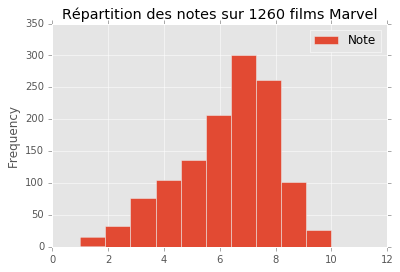

In [10]:
path_raw= r"C:\Users\alize\Anaconda3\Scripts\Projet\Raw_data"
files_raw=lister_files(path_raw)
df_raw=df_files(files_raw)
graph_repart(df_raw)

In [11]:
deciles(df_raw)

0.0     1
0.1     4
0.2     5
0.3     6
0.4     6
0.5     7
0.6     7
0.7     8
0.8     8
0.9     9
1.0    10
Name: Note, dtype: object

La note médiane n'est pas 5 et 7 est la note la plus fréquente. On choisit donc de considérer tous les fichiers notés 6 ou 7 comme neutres, de ne pas les considérer dans le cadre de ce projet qui se limite à identifier si, binairement, l'avis est positif ou négatif. De plus, pour que l'échantillon soit équilibré, on supprime 24 avis notés 8. Il y a ainsi 364 avis positifs et exactement autant de négatifs.

## Vérification

In [12]:
path_new = r"C:\Users\alize\Anaconda3\Scripts\Projet\Data_marvel"
files_new=lister_files(path_new)
df_new=df_files(files_new)

In [13]:
print(lister_films(df_raw), "\n", lister_films(df_new))

['AS' 'Av' 'CA' 'DP' 'DS' 'GG' 'Sb' 'SM' 'XC' 'XD' 'XM' 'AU' 'IH' 'St' 'Th'
 'TT' 'AM' 'CS' 'CV' 'IM' 'It'] 
 ['AS' 'Av' 'CA' 'DP' 'DS' 'GG' 'Sb' 'SM' 'XC' 'XD' 'XM' 'AU' 'IH' 'St' 'Th'
 'TT' 'AM' 'CS' 'CV' 'IM' 'It']


Aucun film n'a été éliminé.

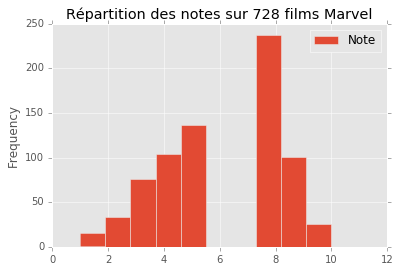

In [14]:
graph_repart(df_new)

On a simplement tronqué une partie des données, correspondant aux avis définis comme neutres.

In [15]:
#Enregistrement de la liste des fichiers dans chaque dossier.
df_raw.to_excel("Liste_raw.xlsx", index=False)
df_new.to_excel("Liste_new.xlsx", index=False)

# Construction de la base

In [16]:
base=pd.DataFrame(columns=["Note", "Film", "Fichier"])
i=0
for file in files_new :
    path = r"Data_marvel/"+file
    temp=pd.read_csv(path, sep = "\t", engine="python", header=None, names = ["Note", "Avis"], quotechar="\"", quoting=3)
    base= pd.concat([base, temp], ignore_index=True)
    if file[1].isdigit() :
        base.ix[i, "Film"] = file[2:4]
    else : 
        base.ix[i, "Film"] =file[1:3]
    base.ix[i, "Fichier"]=file    
    i+=1

In [17]:
base.tail()

,Avis,Fichier,Film,Note
723,"Je ne m'y attendais pas, j'ai été soufflé : X-...",9XD53.txt,XD,9.0
724,En ces temps où Hollywood ne voit plus que des...,9XM17.txt,XM,9.0
725,Le début des années 2000. Période charnière du...,9XM18.txt,XM,9.0
726,En ces temps où Hollywood ne voit plus que des...,9XM6.txt,XM,9.0
727,Le début des années 2000. Période charnière du...,9XM8.txt,XM,9.0


Il y a des doublons dans les fichiers. On supprime ces doublons, qui risqueraient autrement d'altérer les résultats en surpondérant certains mots, de fait présents plus souvent, en plus de ralentir les calculs sans raison avec des éléments impertinents.

In [18]:
base.dropna(axis=0, how='any', subset=["Avis"], inplace=True)
base.drop_duplicates(subset="Avis", inplace=True)
base.reset_index(inplace=True, drop=True)

In [26]:
base.to_csv("base.csv", sep='\t')

In [20]:
len(base)

628

In [21]:
base["Avis"].count()

628

In [22]:
for i in range (len(base)) :
    base.ix[i, "Longueur"]=len(base["Avis"][i])

In [23]:
base.head()

,Avis,Fichier,Film,Note,Longueur
0,Après la trilogie ronflante de Sam Rémi sans-f...,10AS44.txt,AS,10.0,1555.0
1,"On l'attendait, le voilà. Joss Whedon a créé l...",10Av15.txt,Av,10.0,3136.0
2,Fantasme des lecteurs de comics depuis des ann...,10Av19.txt,Av,10.0,13442.0
3,"Tout le monde commence ses critiques par ""je m...",10Av22.txt,Av,10.0,6722.0
4,"Après une introduction qui, malgré une certain...",10Av33.txt,Av,10.0,1446.0


In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

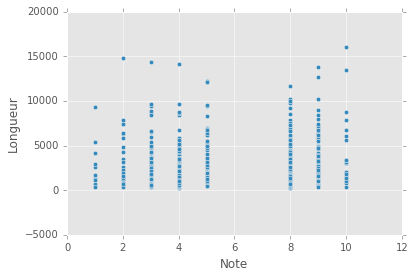

In [147]:
base.plot(kind="scatter", y="Longueur de la critique", x="Note")

In [25]:
base[["Longueur", "Note"]].corr().ix["Longueur", "Note"]

0.0035614533419943196